## 8.3.2 드롭아웃을 이용한 성능 최적화

In [1]:
# 라이브러리 호출
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# 데이터셋 내려받기
trainset = torchvision.datasets.FashionMNIST(root='/', train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]


Extracting /FashionMNIST/raw/train-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting /FashionMNIST/raw/train-labels-idx1-ubyte.gz to /FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]


Extracting /FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.90MB/s]

Extracting /FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /FashionMNIST/raw



In [3]:
# 데이터셋을 메모리로 가져오기
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [4]:
# 데이터셋 분리
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
2


In [5]:
# 이미지 데이터를 출력하기 위한 전처리
def imshow(img, title):
    plt.figure(figsize=(batch_size * 4, 4)) # 출력할 개별 이미지의 크기 지정
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0))) # matplotlib로 출력하려면 이미지가 w,h,c 형태여야함
    plt.title(title)
    plt.show()

In [6]:
# 이미지 데이터 출력 함수
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader)) # 이미지 크기는 (4,28,28,1)

    img = torchvision.utils.make_grid(images) # 좌표에 이미지 픽셀을 대응시켜 그리드 형태로 출력
    imshow(img, title=[str(x.item()) for x in labels]) # imshow 함수를 사용해 데이터의 형태를 c,h,w에서 h,w,c로 변경

    return images, labels

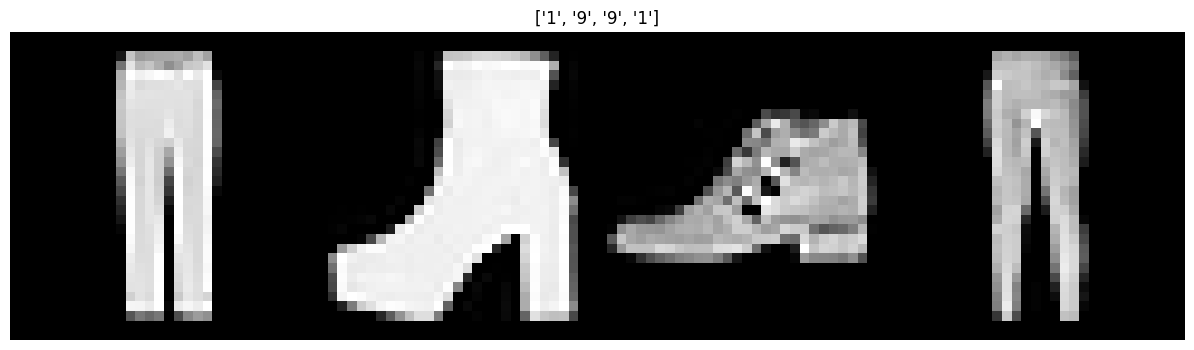

In [7]:
# 이미지 출력
images, labels = show_batch_images(trainloader)

In [8]:
# 배치 정규화가 적용되지 않은 네트워크
class NormalNet(nn.Module):
    def __init__(self):
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28*28 크기의 이미지로 입력은 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10) # FashionMNIST의 클래스는 총 10개
        ) # nn.Sequential을 사용하면 forward() 함수에서 계층별로 가독성 있게 코드 구현 가능

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x) # nn.Sequential에서 정의한 계층 호출
        return x

In [9]:
# 배치 정규화가 포함된 네트워크
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48), # 배치 정규화 적용
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
# 배치 정규화가 적용되지 않은 모델 선언
model = NormalNet().to(device)
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [11]:
# 배치 정규화가 적용된 모델 선언
model_bn = BNNet().to(device)
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [12]:
# 데이터셋 메모리로 불러오기
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [13]:
# 옵티마이저, 손실 함수 지정
loss_fn = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

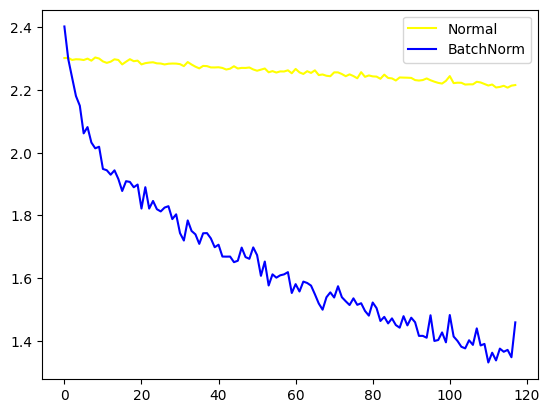

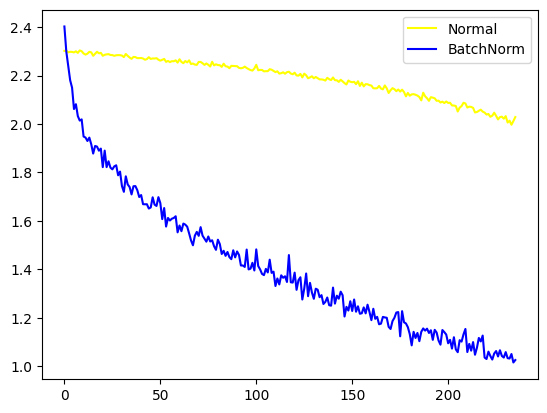

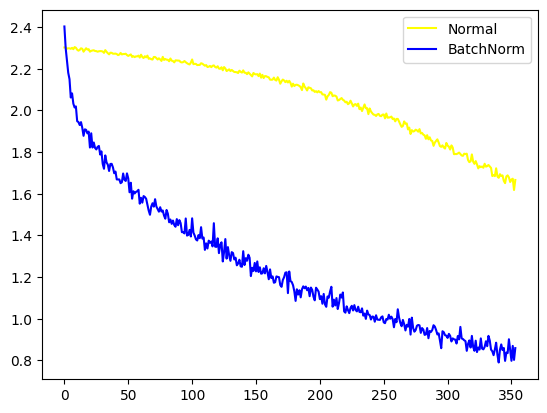

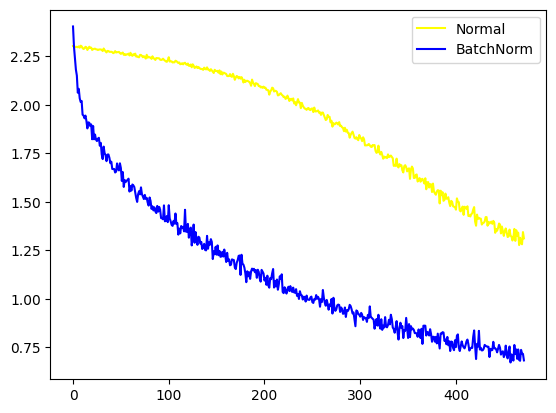

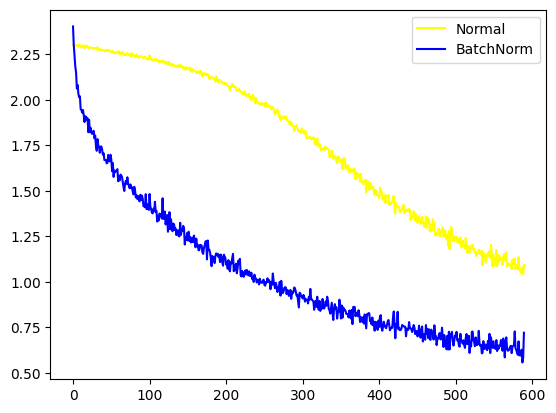

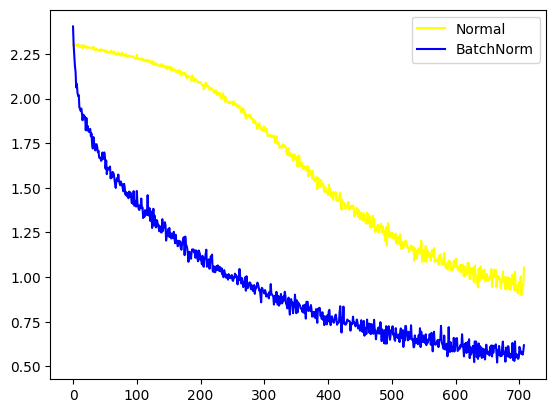

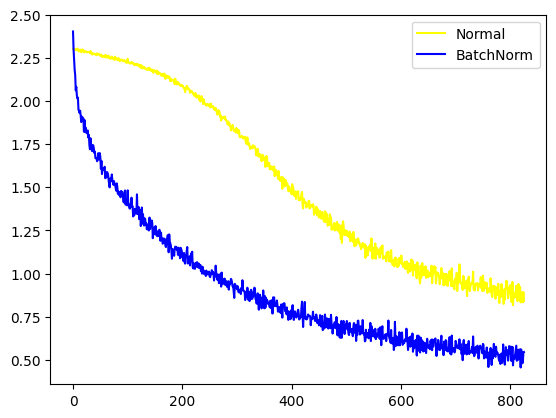

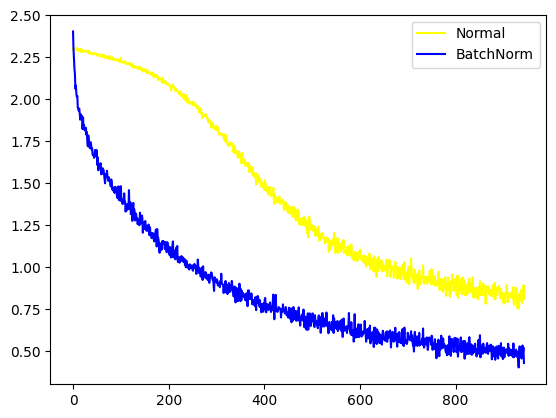

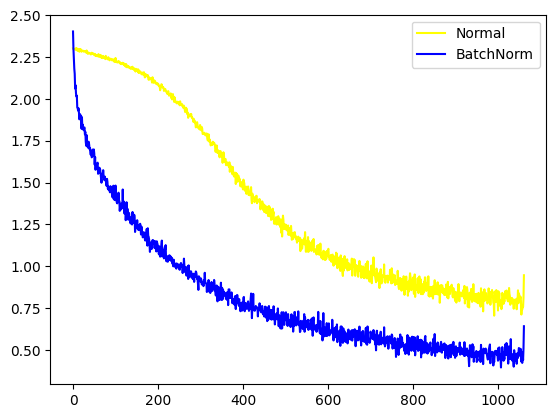

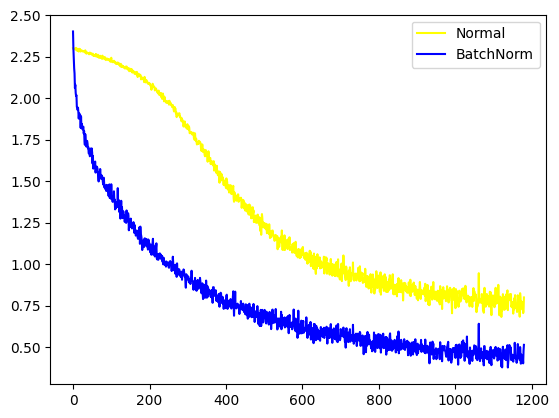

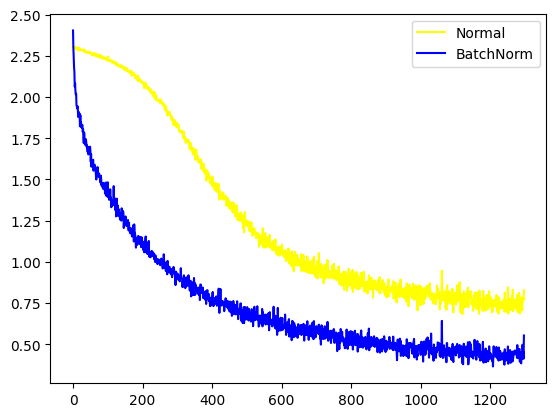

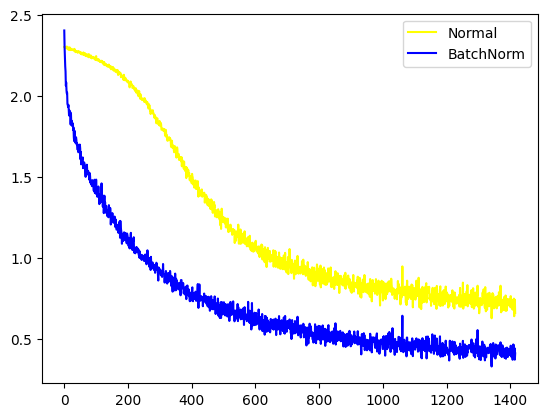

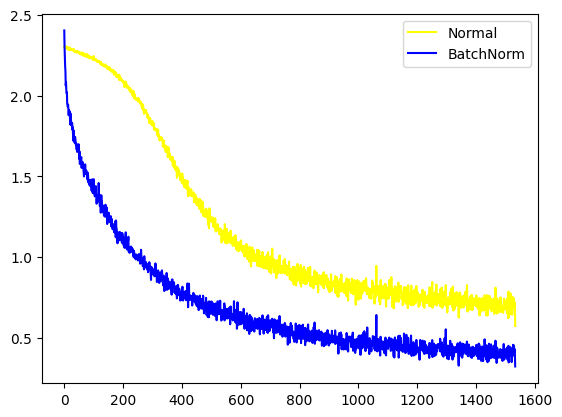

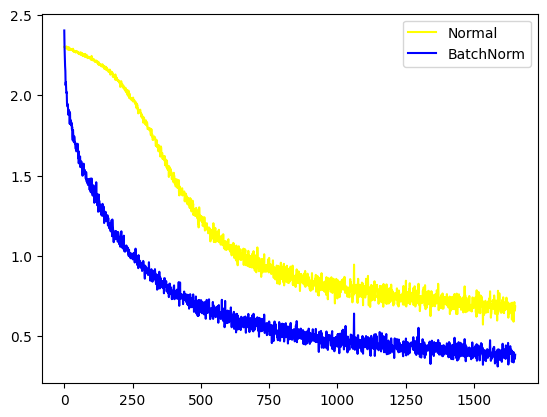

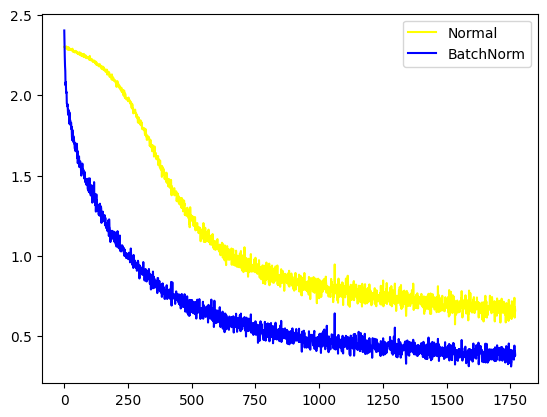

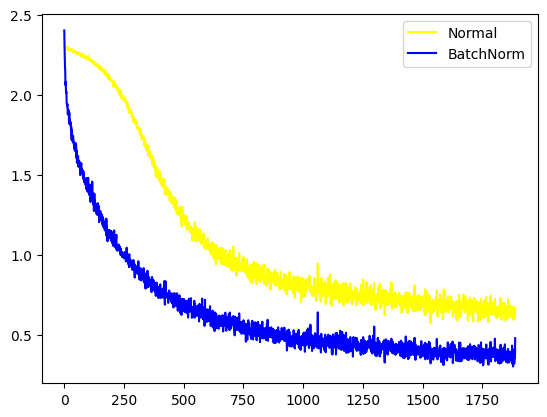

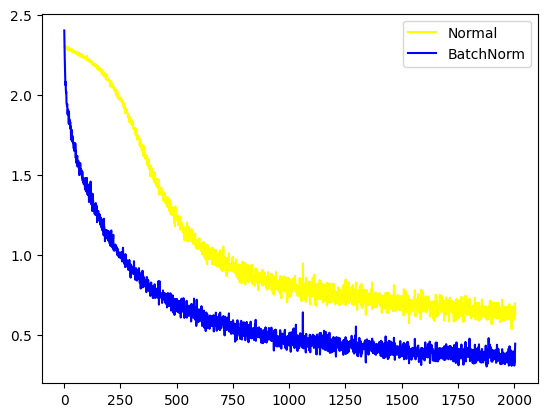

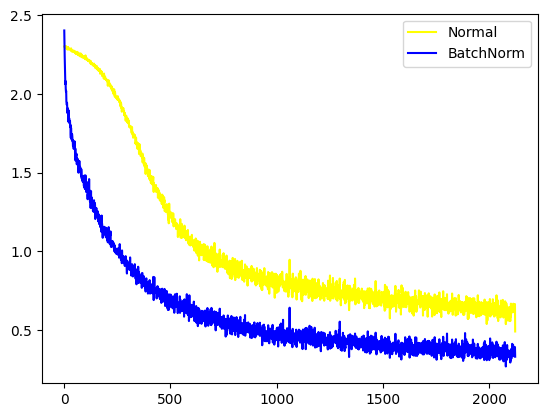

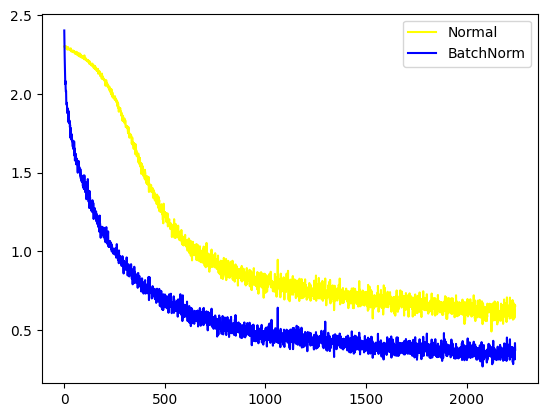

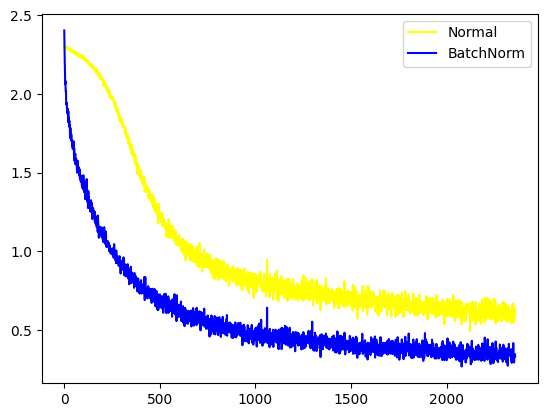

In [14]:
# 모델 학습
loss_arr = []
loss_bn_arr = []
max_epochs = 20

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad() # 배치 정규화가 적용되지 않은 모델의 학습
        outputs = model(inputs).to(device)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        opt_bn.zero_grad() # 배치 정규화가 적용된 모델의 학습
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')
    plt.legend()
    plt.show()

In [15]:
# 데이터셋의 분포를 출력하기 위한 전처리
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1) # 훈련 데이터셋이 -1에서 1 사이 값을 갖도록 조정
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1) # 훈련 데이터셋 값의 범위가 정규분포를 갖도록 조정
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

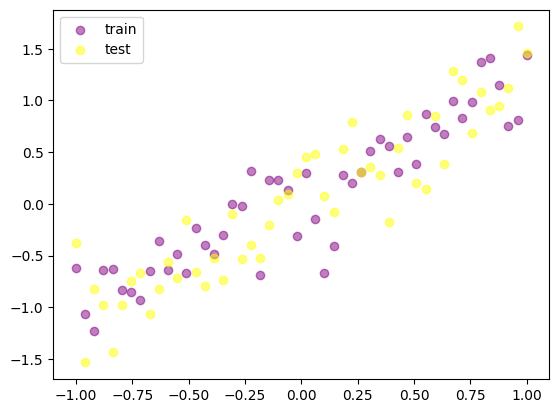

In [16]:
# 데이터 분포를 그래프로 출력
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [17]:
# 드롭아웃을 위한 모델 생성
N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
) # 드롭아웃 적용 안 된 모델

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2), # 드롭아웃 적용
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
) # 드롭아웃 적용 모델

In [18]:
# 옵티마이저와 손실 함수 지정
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss().to(device)

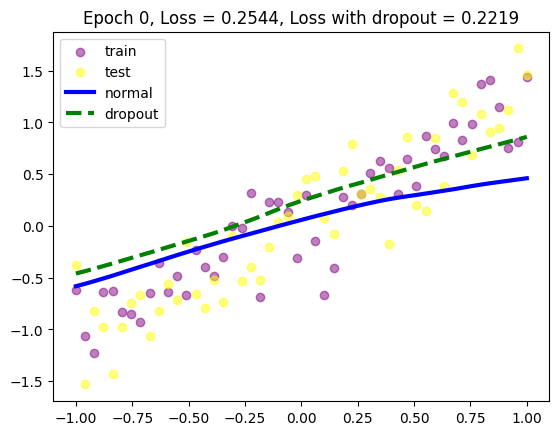

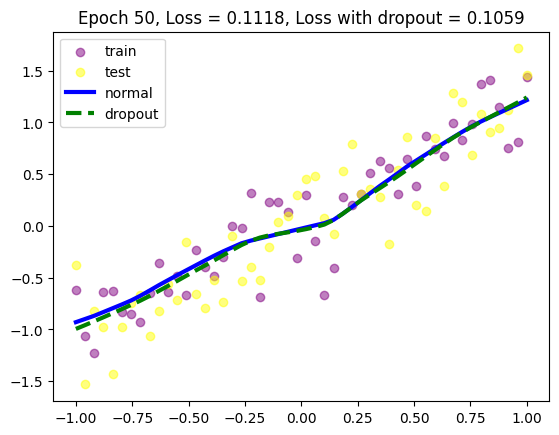

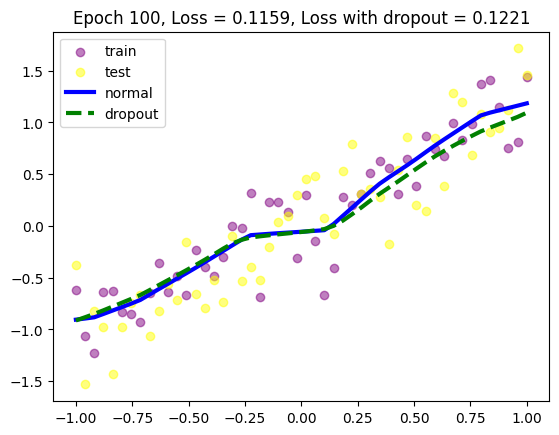

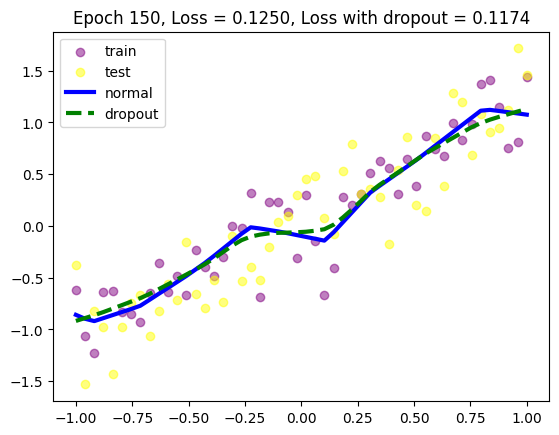

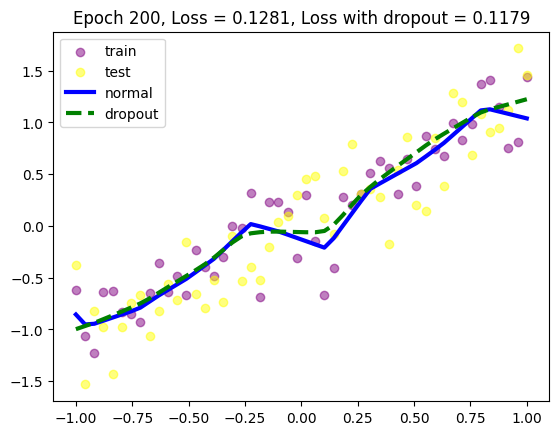

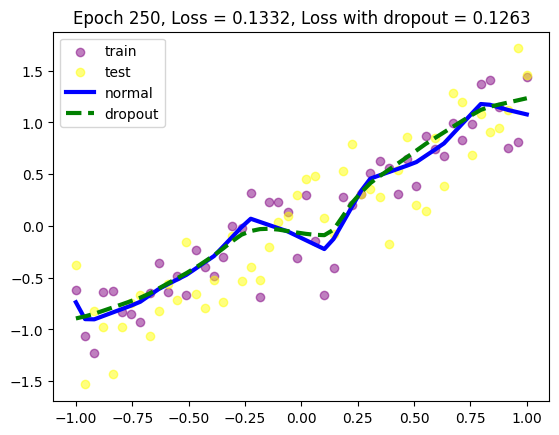

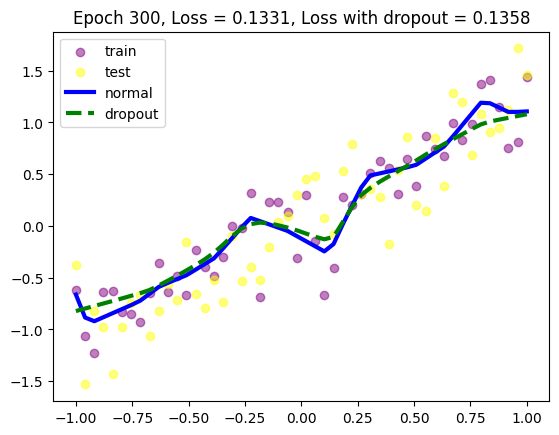

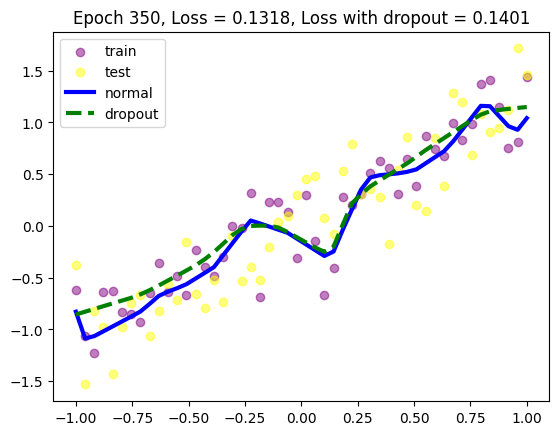

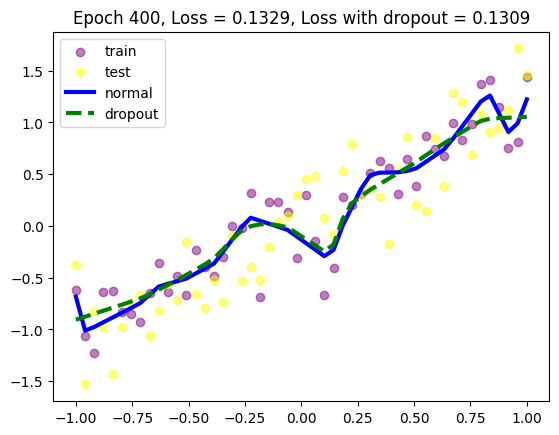

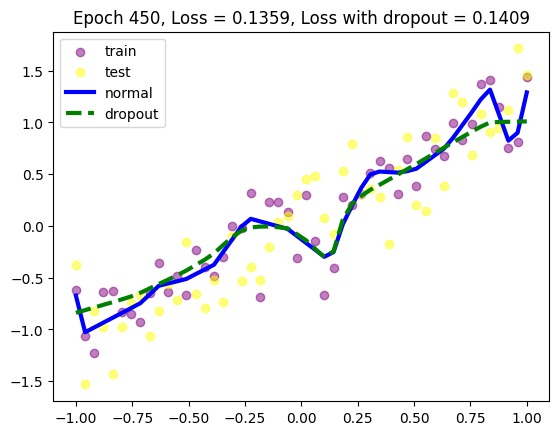

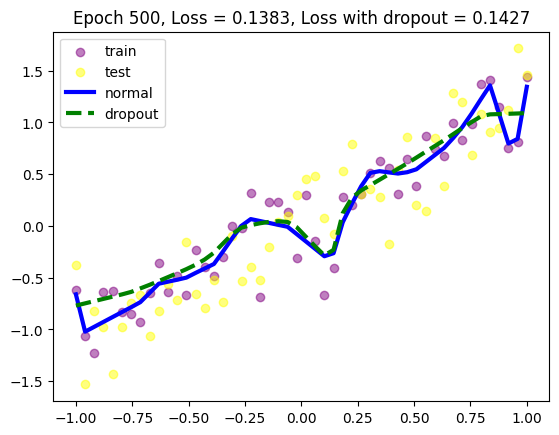

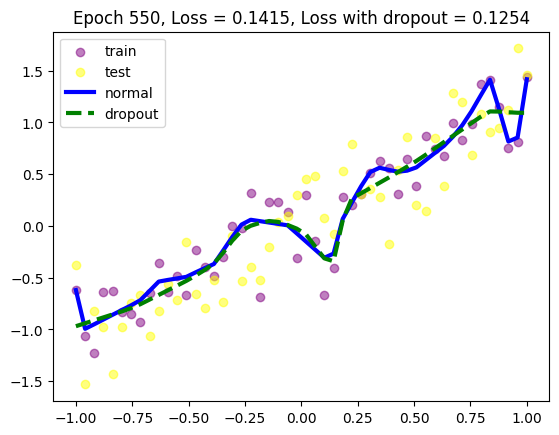

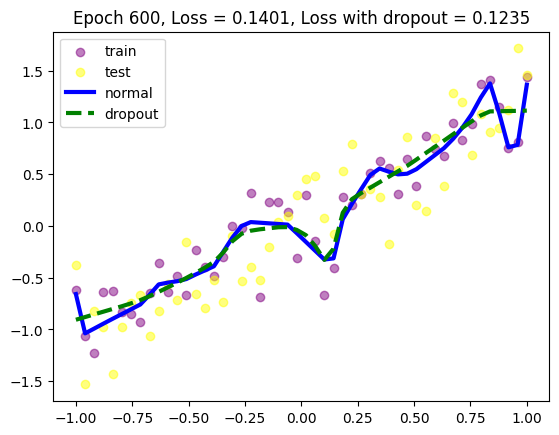

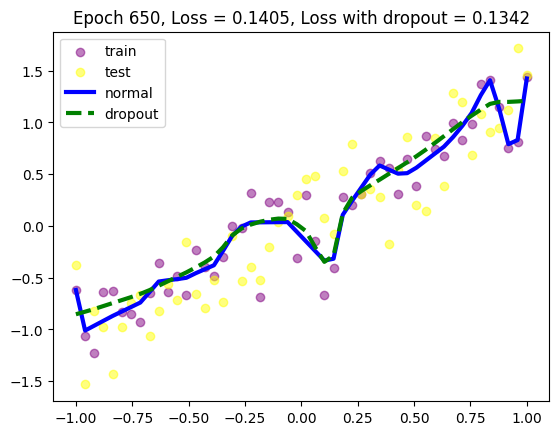

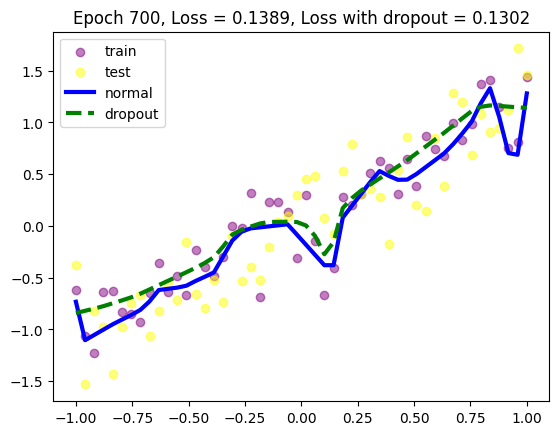

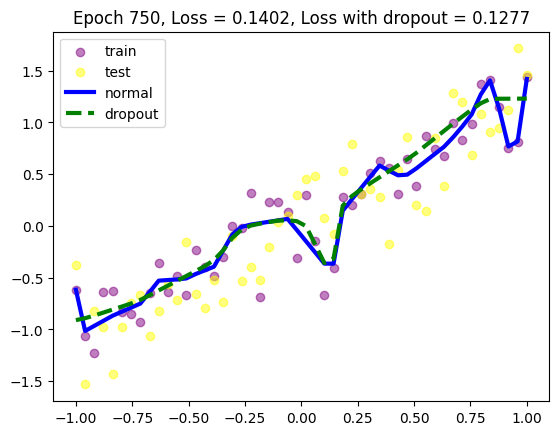

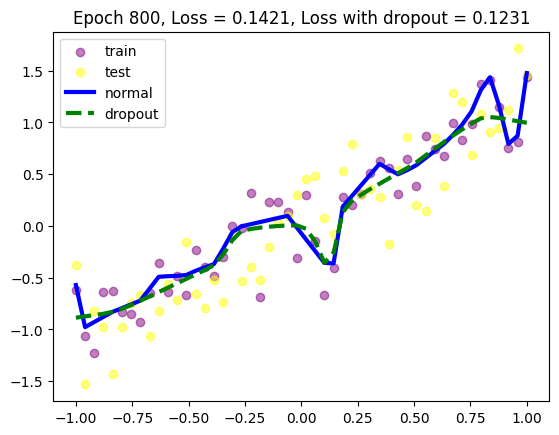

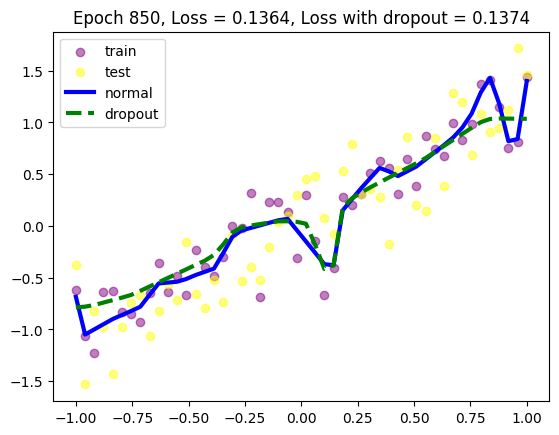

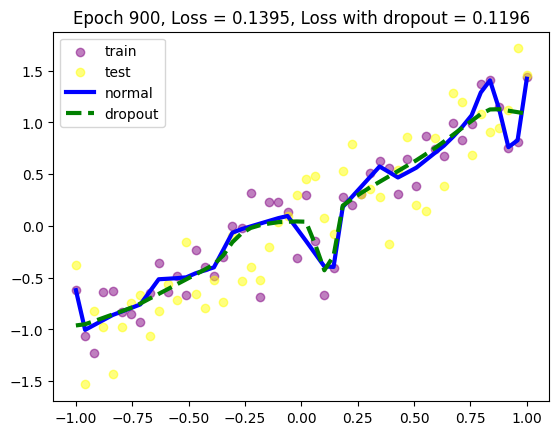

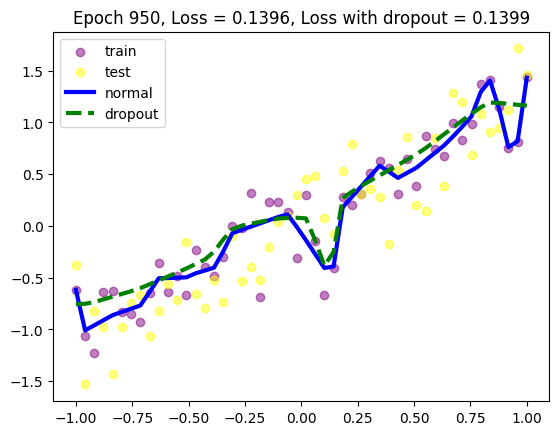

In [19]:
# 모델 학습
max_epochs = 1000
for epoch in range(max_epochs):
    pred = model(x_train) # 드롭아웃이 적용되지 않은 모델 학습
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_dropout = model_dropout(x_train) # 드롭아웃이 적용된 모델 학습
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50 == 0: # epoch를 50으로 나눈 나머지가 0이면 다음 진행
        model.eval()
        model_dropout.eval()

        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)

        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)

        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal') # 파란색 실선으로 x축은 테스트 데이터셋, y축은 드롭아웃이 적용되지 않은 모델의 결과를 그래프로 출력
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout') # 초록색 점선으로 x축은 테스트 데이터셋, y축은 드롭아웃이 적용된 모델의 결과를 그래프로 출력

        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout)) # 에포크, 드롭아웃이 적용되지 않은 모델의 오차, 드롭아웃이 적용된 모델의 오차를 타이틀로 출력
        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)

## 8.3.3 조기 종료를 이용한 성능 최적화

In [ ]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models # 사전 학습된 모델을 이용하고자 할 때 사용하는 라이브러리
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot') # 출력 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 하는 스타일
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 데이터셋 전처리
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [ ]:
# 데이터셋 가져오기
train_dataset = datasets.ImageFolder(
    root=r'/content/content/train',
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root=r'/content/content/test',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

In [ ]:
# 모델 생성
def resnet50(pretrained=True):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if requires_grad == False: # 파라미터를 고정하여 backward() 중에 기울기가 계산되지 않도록 함. requires_grad=False를 파라미터로 받았기 때문에 해당 구문 실행됨
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True: # 파라미터 값이 backward() 중에 기울기 계산에 반영됨
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 2) # 마지막 분류를 위한 계층은 학습 진행
    return model

In [ ]:
# 학습률 감소
class LRScheduler():
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            ) # 학습 과정에서 모델 성능에 대한 개선이 없을 경우 학습률 값 조절하여 모델 개선 유도
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss) # 실제 학습률 업데이트

In [ ]:
# 조기 종료
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0, path='../checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None # 검증 데이터셋에 대한 오차 최적화 값(오차가 가장 낮은 값)
        self.early_stop = False # 조기 종료를 의미. 초깃값은 False
        self.val_loss_min = np.Inf # np.Inf(infinity)는 넘파이에서 무한대를 표현
        self.delta = delta
        self.path = path # 모델이 저장될 경로

    def __call__(self, val_loss, model): # 에포크만큼 학습이 반복되면서 best_loss가 갱신. best_loss에 진전이 없으면 조기 종료한 후 모델을 저장
        score = -val_loss

        if self.best_score is None: # best_score에 값이 존재하지 않으면 실행
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta: # best_score + delta가 score보다 크면 실행
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else: # 그 외 모든 경우에 실행
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model): # 검증 데이터셋에 대한 오차가 감소하면 모델을 저장
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path) # 지정된 경로에 모델 저장
        self.val_loss_min = val_loss

In [ ]:
# 인수 값 지정
parser = argparse.ArgumentParser() # 인수 값을 받을 수 있는 인스턴스 생성
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true') # 조기 종료에 대한 인수
args = vars(parser.parse_args())

In [ ]:
# 사전 훈련된 모델의 파라미터 확인
print(f"Computation device: {device}\n") # CPU를 사용하는지 GPU를 사용하는지 검사
model = models.resnet50(weights='DEFAULT').to(device) # 사전 훈련된 ResNet50 사용
total_params = sum(p.numel() for p in model.parameters()) # 총 파라미터 수
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad) # 학습 가능한 파라미터 수
print(f"{total_trainable_params:,} training parameters.")

In [ ]:
# 옵티마이저와 손실 함수 지정
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 오차, 정확도 및 모델의 이름에 대한 문자열
loss_plot_name = 'loss' # 오차 출력에 대한 문자열
acc_plot_name = 'accuracy' # 정확도 출력에 대한 문자열
model_name = 'model' # 모델을 저장하기 위한 문자열

In [ ]:
# 오차, 정확도 및 모델의 이름에 대한 문자열
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss' # 학습률 감소를 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'lrs_accuracy' # 학습률 감소를 적용했을 때의 정확도에 대한 문자열
    model_name = 'lrs_model' # 학습률 감소를 적용했을 때의 모델에 대한 문자열
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss' # 조기 종료를 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'es_accuracy' # 조기 종료를 적용했을 때의 정확도에 대한 문자열
    model_name = 'es_model' # 조기 종료를 적용했을 때의 모델에 대한 문자열

In [ ]:
# 모델 학습 함수
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)) # 훈련 진행 과정을 시각적으로 표현
    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [ ]:
# 모델 검증 함수
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size)) # 모델 검증 과정을 시각적으로 표현
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()

        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [ ]:
# 모델 학습
train_loss, train_accuracy = [], [] # 훈련 데이터셋을 이용한 모델 학습 결과를 저장하기 위한 변수
val_loss, val_accuracy = [], [] # 검증 데이터셋을 이용한 모델 학습 결과를 저장하기 위한 변수
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args['lr_scheduler']: # 인수 값이 lr scheduler일 경우
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']: # 인수 값이 early stopping일 경우
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

In [ ]:
# 모델 학습 결과 출력
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('Saving model...')
torch.save(model.state_dict(), f"../chap08/img/{model_name}.pth")
print('TRAINING COMPLETE')